In [1]:
!pip install wordcloud


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
class data_Loader:
    def __init__(self, path):
        self.path = path
        self.data = None

    def load_data(self):
        # Load emails
        self.data = pd.read_csv(self.path, encoding='latin1')
        return self.data

In [3]:
# call class
path = 'spam.csv'
data_loader = data_Loader(path)
data = data_loader.load_data()
print(data.head())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
class data_Analyzer(data_Loader):
    def __init__(self, path):
        super().__init__(path)

    def clean_data(self):
        # Rename columns
        self.data.columns = ['label', 'message', 'col3', 'col4', 'col5']
        # Drop unnecessary columns
        self.data = self.data.drop(['col3', 'col4', 'col5'], axis=1)
        # Drop rows with missing values
        self.data.dropna(inplace=True)
        return self.data

    def plot_distribution(self):
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.data, x='label')
        plt.title('Distribution of Ham and Spam Messages')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.show()

    def plot_message_length_distribution(self):
        self.data['message_length'] = self.data['message'].apply(len)

        plt.figure(figsize=(8, 6))
        sns.histplot(self.data[self.data['label'] == 'ham']['message_length'], kde=True, color='blue', label='Ham', bins=30)
        sns.histplot(self.data[self.data['label'] == 'spam']['message_length'], kde=True, color='red', label='Spam', bins=30)
        plt.title('Distribution of Message Length')
        plt.xlabel('Message Length')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    def get_message_length_stats(self):
        self.data['message_length'] = self.data['message'].apply(len)
        ham_stats = self.data[self.data['label'] == 'ham']['message_length'].describe()
        spam_stats = self.data[self.data['label'] == 'spam']['message_length'].describe()
        return ham_stats, spam_stats

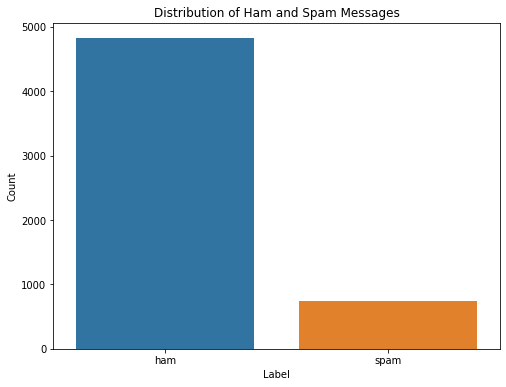

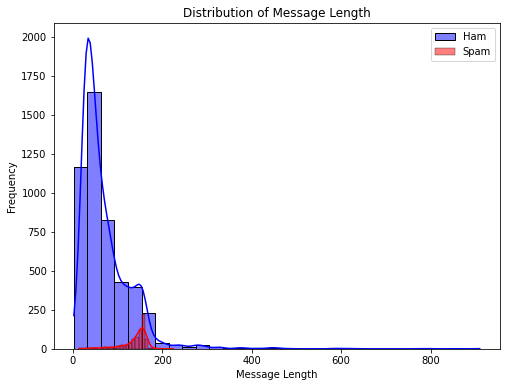

Ham Message Length Stats:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: message_length, dtype: float64

Spam Message Length Stats:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: message_length, dtype: float64


In [5]:
# call data analyzer
data_analyzer = data_Analyzer(path)
data = data_analyzer.load_data()
cleaned_data = data_analyzer.clean_data()
data_analyzer.plot_distribution()
data_analyzer.plot_message_length_distribution()
ham_stats, spam_stats = data_analyzer.get_message_length_stats()
print("Ham Message Length Stats:\n", ham_stats)
print("\nSpam Message Length Stats:\n", spam_stats)


In [6]:
class AdvancedDataAnalyzer(data_Analyzer):
    def __init__(self, path):
        super().__init__(path)
        
    def clean_text(self, text):
        # Remove HTML tags
        text = re.sub('<.*?>', '', text)
        # Remove non-alphabetic characters and convert to lowercase
        text = re.sub('[^a-zA-Z]', ' ', text).lower()
        # Tokenize the text
        words = nltk.word_tokenize(text)
        # Remove stopwords
        words = [w for w in words if w not in stopwords.words('english')]
        # Stem the words
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]
        # Join the words back into a string
        text = ' '.join(words)
        return text
    
    def preprocess_data(self):
        self.data['cleaned_message'] = self.data['message'].apply(self.clean_text)
        return self.data

    def generate_word_cloud(self, label, colormap='viridis'):
        text = ' '.join(self.data[self.data['label'] == label]['message'])
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {label.capitalize()} Messages', fontsize=20)
        plt.show()

    def get_top_words(self, label, n=10):
        text = ' '.join(self.data[self.data['label'] == label]['cleaned_message'])
        words = text.split()
        word_counts = Counter(words)
        return word_counts.most_common(n)

    def plot_top_words(self, label, n=10):
        top_words = self.get_top_words(label, n)
        words, counts = zip(*top_words)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(counts), y=list(words), palette='viridis')
        plt.title(f'Top {n} Words in {label.capitalize()} Messages', fontsize=20)
        plt.xlabel('Count')
        plt.ylabel('Words')
        plt.show()
        
        
    def plot_word_length_distribution(self):
        self.data['word_length'] = self.data['cleaned_message'].apply(lambda x: len(x.split()))
        
        plt.figure(figsize=(8, 6))
        sns.histplot(self.data[self.data['label'] == 'ham']['word_length'], kde=True, color='blue', label='Ham', bins=30)
        sns.histplot(self.data[self.data['label'] == 'spam']['word_length'], kde=True, color='red', label='Spam', bins=30)
        plt.title('Distribution of Word Count per Message')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    def plot_box_plots(self):
        self.data['message_length'] = self.data['message'].apply(len)
        self.data['word_length'] = self.data['cleaned_message'].apply(lambda x: len(x.split()))
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='label', y='message_length', data=self.data, palette='viridis')
        plt.title('Box Plot of Message Length by Label', fontsize=20)
        plt.xlabel('Label')
        plt.ylabel('Message Length')
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='label', y='word_length', data=self.data, palette='viridis')
        plt.title('Box Plot of Word Count by Label', fontsize=20)
        plt.xlabel('Label')
        plt.ylabel('Word Count')
        plt.show()


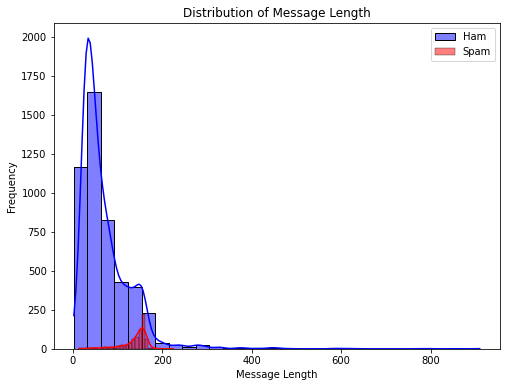

Ham Message Length Stats:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: message_length, dtype: float64

Spam Message Length Stats:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: message_length, dtype: float64


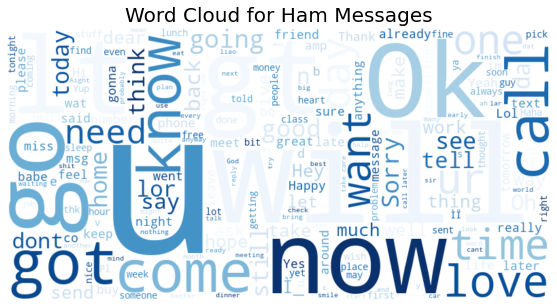

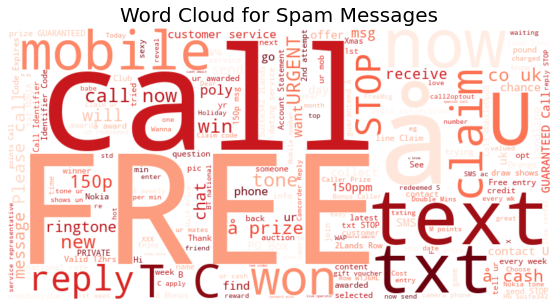

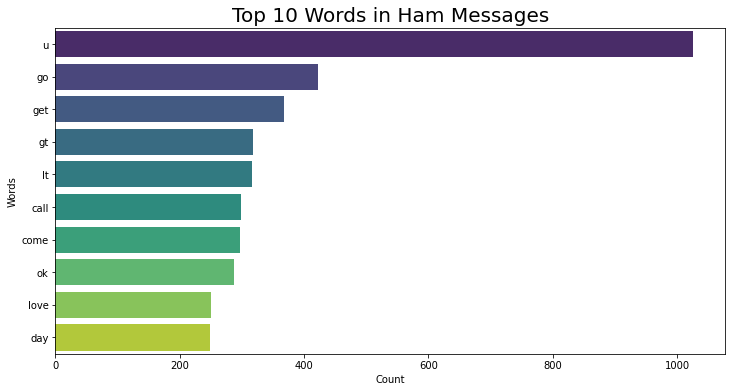

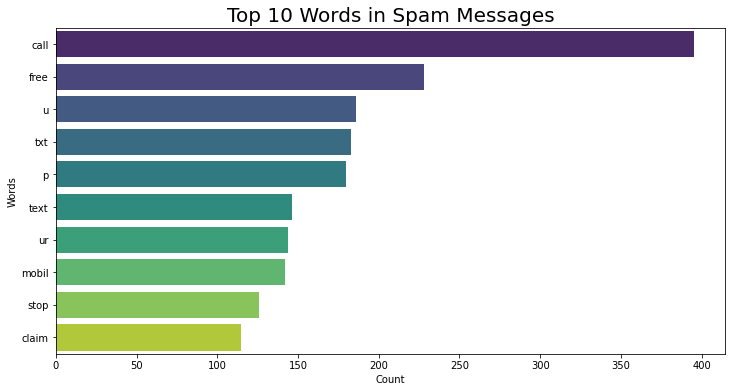

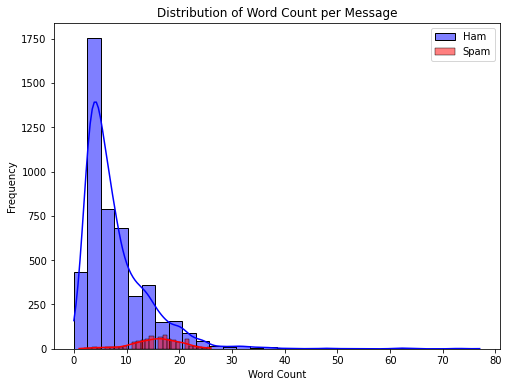

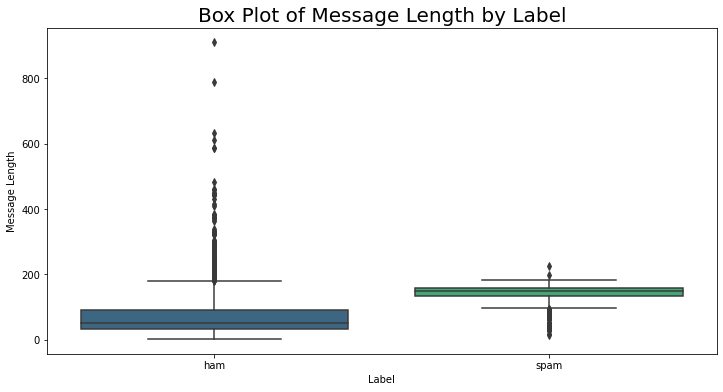

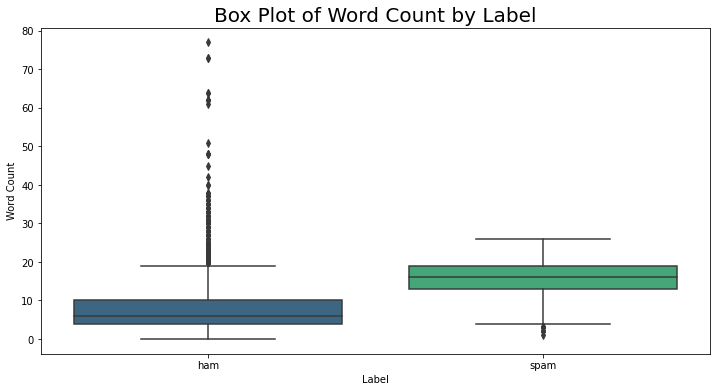

In [8]:
advanced_analyzer = AdvancedDataAnalyzer(path)
data = advanced_analyzer.load_data()
cleaned_data = advanced_analyzer.clean_data()
preprocessed_data = advanced_analyzer.preprocess_data()
# advanced_analyzer.plot_distribution()
advanced_analyzer.plot_message_length_distribution()
ham_stats, spam_stats = advanced_analyzer.get_message_length_stats()
print("Ham Message Length Stats:\n", ham_stats)
print("\nSpam Message Length Stats:\n", spam_stats)
advanced_analyzer.generate_word_cloud('ham', colormap='Blues')
advanced_analyzer.generate_word_cloud('spam', colormap='Reds')
advanced_analyzer.plot_top_words('ham')
advanced_analyzer.plot_top_words('spam')
advanced_analyzer.plot_word_length_distribution()
advanced_analyzer.plot_box_plots()

In [14]:
data.head()

,label,message,col3,col4,col5
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
advanced_analyzer.data.head()

,label,message,cleaned_message,message_length,word_length
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,16
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,155,21
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,9
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though,61,7
